# In this notebook we will calibrate a linear model using the Bayesian Approach

This notebook contains the full notebook with solutions. For the unsolved one, see the other file!

Thanks to ChatGPT for helping in the creation and comments of the code!

Thanks to Pablo for correcting ChatGPT on the few mistakes it made and for writing more comments!

## Generating data

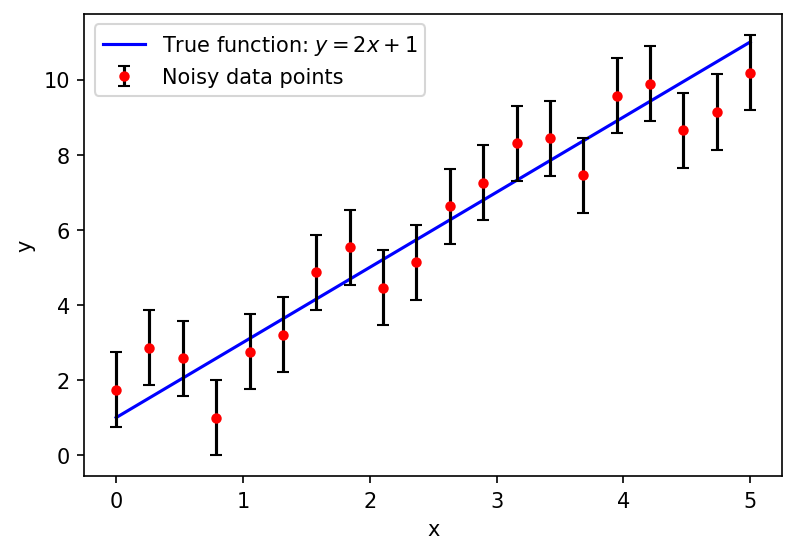

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# Set random seed for reproducibility
np.random.seed(142857)

# Generate 20 points normally distributed around a straight line y = 2x + 1
x = np.linspace(0, 5, 20)

# Noise level
noise_size = 1
noise = np.random.normal(0, noise_size, size=x.shape)

def true_f(x,a0=1,a1=2):
    return x*a1 + a0

def model_f(x,a0,a1):
    return x*a1 + a0
#Seems silly that we are basically defining the same function twice, but this way we can play with
# a different generating function for the true values later if we wanted to

y = true_f(x) + noise


# Generating function
y_true = true_f(x)

# Plot the points and the generating function
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(x, y_true, label='True function: $y = 2x + 1$', color='blue')
plt.errorbar(x, y, yerr=noise_size, fmt='o',markersize=4, color='red', label='Noisy data points', ecolor='black', elinewidth=1.5, capsize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plt.grid(True)
plt.show()


## Bayesian calibration

Acceptance ratio (should be around 1/3): 0.38


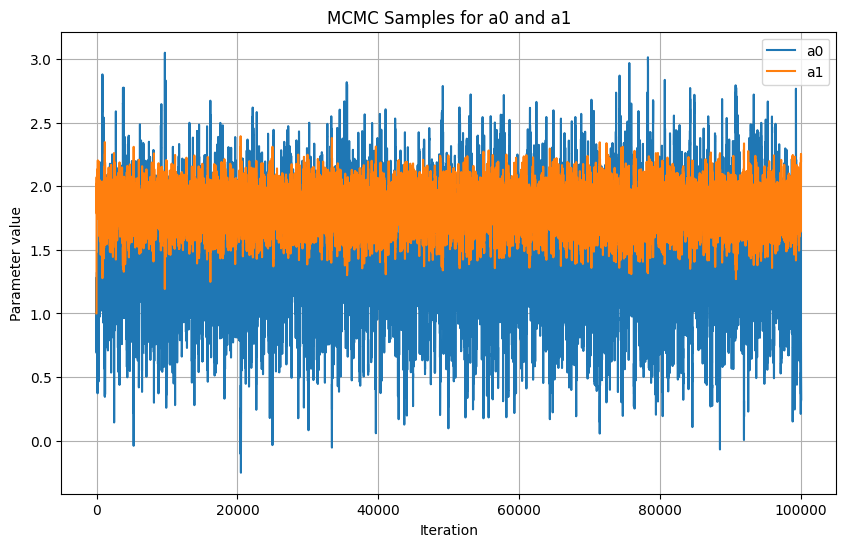

In [45]:
# Bayesian calibration using MCMC with Metropolis-Hastings algorithm

#Since likelihoods and priors usually look like exponentials (e^{stuff}), it is customary to work with their likelihoods.
#This makes it easier when handeling very tiny numbers, and they can be exponentiated later to build the posterior when doing the metrolopis algorithm


#Assuming a gaussian likelihood, what sits on top of it its what we usually call "chi2". We are also
# assuming that we know the error bars of the points perfectly well and that is "sigma", but if
# we didn't know it, there are ways of estimating it at the same time:
def log_likelihood(a0, a1, x, y, sigma=1):
    y_model = a0 + a1 * x
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2)



#We have some prior knowledge of around where these things should be
a0_mu_prior=0
a1_mu_prior=1

#How sure are we about that? Bigger sigmas here mean we are less sure:
a0_sigma_prior=5
a1_sigma_prior=5

def log_prior(a0, a1):
    return -0.5 * (  ((a0-a0_mu_prior) / a0_sigma_prior) ** 2  + ((a1 - a1_mu_prior) / a1_sigma_prior) ** 2  )

def log_posterior(a0, a1, x, y, sigma=1):
    return log_prior(a0, a1) + log_likelihood(a0, a1, x, y, sigma)

# Initial guess
a0, a1 = 1, 1
n_iterations = 100000


#This step controlls how much we move in the parameter step on each MCMC iteration
step = 0.2

# Storage for samples
samples = np.zeros((n_iterations, 2))
samples[0, :] = [a0, a1]

# Count the number of acceptances
n_acceptances = 0

for i in range(1, n_iterations):
    a0_proposal = a0 + np.random.normal(0, step)
    a1_proposal = a1 + np.random.normal(0, step)
    
    log_posterior_current = log_posterior(a0, a1, x, y, sigma=1)
    log_posterior_proposal = log_posterior(a0_proposal, a1_proposal, x, y, sigma=1)
    
    acceptance_prob = np.exp(log_posterior_proposal - log_posterior_current)
    
    if np.random.rand() < acceptance_prob:
        a0, a1 = a0_proposal, a1_proposal
        n_acceptances += 1
    
    samples[i, :] = [a0, a1]

# Calculate and print the acceptance ratio
acceptance_ratio = n_acceptances / n_iterations
print(f'Acceptance ratio (should be around 1/3): {acceptance_ratio:.2f}')

# Plotting the samples
plt.figure(figsize=(10, 6))
plt.plot(samples[:, 0], label='a0')
plt.plot(samples[:, 1], label='a1')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()
plt.title('MCMC Samples for a0 and a1')
plt.grid(True)
plt.show()


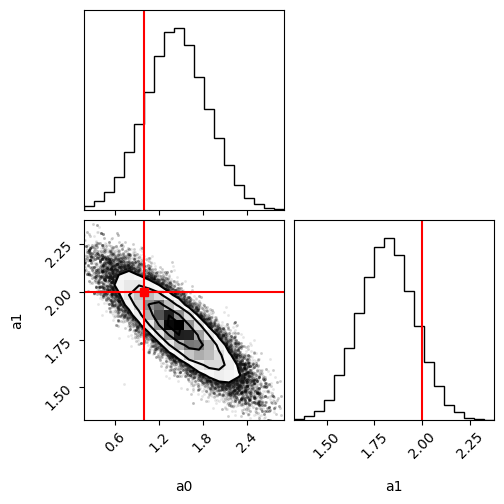

In [46]:
# Determine the limits for the corner plot
a0_min, a0_max = np.percentile(samples[:, 0], [1, 99])*(0.4,1.2)
a1_min, a1_max = np.percentile(samples[:, 1], [1, 99])*(0.9,1.1)

corner.corner(samples, labels=["a0", "a1"], truths=[1, 2],truth_color='r', range=[(a0_min, a0_max), (a1_min, a1_max)], bins=20)
plt.show()


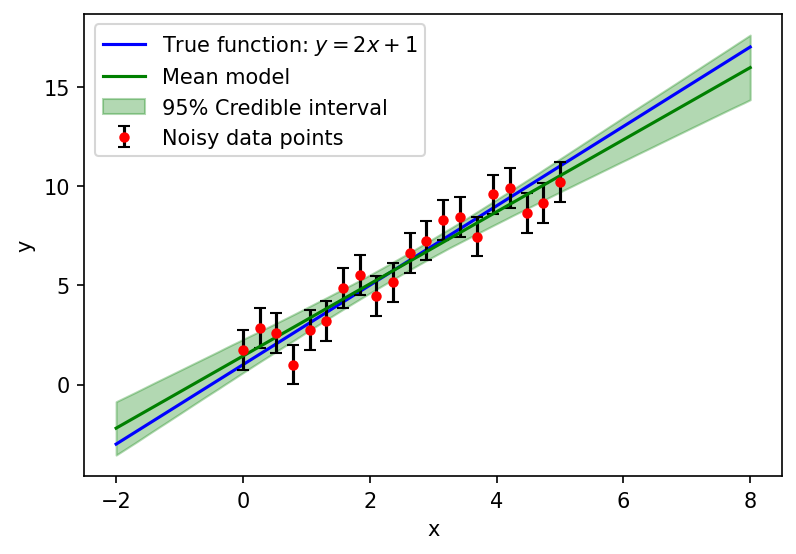

In [48]:
#Now we want to calculate the posterior distribution of the model lines themselves:

# Sampling 10,000 curves from the visited samples
n_samples = 10000
indices = np.random.choice(range(n_iterations), n_samples, replace=True)
sampled_a0 = samples[indices, 0]
sampled_a1 = samples[indices, 1]

x_extended = np.linspace(-2, 8, 100)
y_true_extended=true_f(x_extended)


# Generate y values for each sampled parameter set
y_samples = np.array([a0 + a1 * x_extended for a0, a1 in zip(sampled_a0, sampled_a1)])

# Calculate mean and credible intervals for each x
y_mean = np.mean(y_samples, axis=0)
y_lower = np.percentile(y_samples, 2.5, axis=0)
y_upper = np.percentile(y_samples, 97.5, axis=0)

# Plotting the estimated mean model and credible intervals
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(x_extended, y_true_extended, label='True function: $y = 2x + 1$', color='blue')
plt.errorbar(x, y, yerr=noise_size, fmt='o',markersize=4, color='red', label='Noisy data points', ecolor='black', elinewidth=1.5, capsize=3)
plt.plot(x_extended, y_mean, label='Mean model', color='green')
plt.fill_between(x_extended, y_lower, y_upper, color='green', alpha=0.3, label='95% Credible interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plt.grid(True)

plt.show()



# Extra part, for those seeking a challenge: The role of outliers

What would happen if we have two outliers in our data set? This means probably that our assumption about a Gaussian likelihood is incorrect and that should lead us to wrong results. Lets see that happening and propose a new likelihood to address the issue

BTW, I took this part from another repository I worked on recently, but I got too lazy at this point to comment it too much... so proceed at your own risk :P

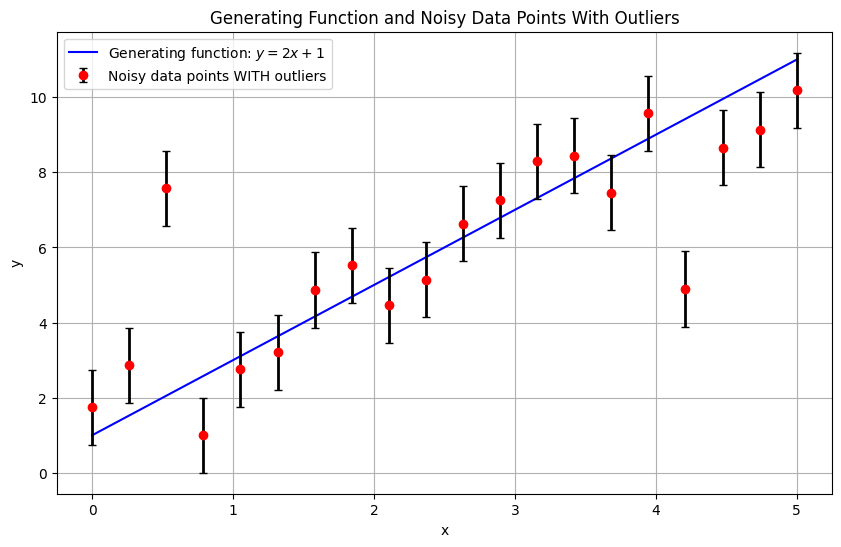

In [38]:
# Set random seed for reproducibility
np.random.seed(142857)

# Generate 20 points normally distributed around a straight line y = 2x + 1
x = np.linspace(0, 5, 20)

# Noise level
noise_size = 1
noise = np.random.normal(0, noise_size, size=x.shape)
y = 2 * x + 1 + noise

# # Artificially modify one of the points to be further away from the generating function
y[2] += 5  # Adding a large value to the first point to create an outlier
y[-4] -= 5  # Adding a large value to the first point to create an outlier

# Generating function
y_true = 2 * x + 1
# Plot the points and the generating function
plt.figure(figsize=(10, 6))
plt.plot(x, y_true, label='Generating function: $y = 2x + 1$', color='blue')
plt.errorbar(x, y, yerr=noise_size, fmt='o', color='red', label='Noisy data points WITH outliers', ecolor='black', elinewidth=2, capsize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Generating Function and Noisy Data Points With Outliers')
plt.grid(True)
plt.show()


Acceptance ratio: 0.38


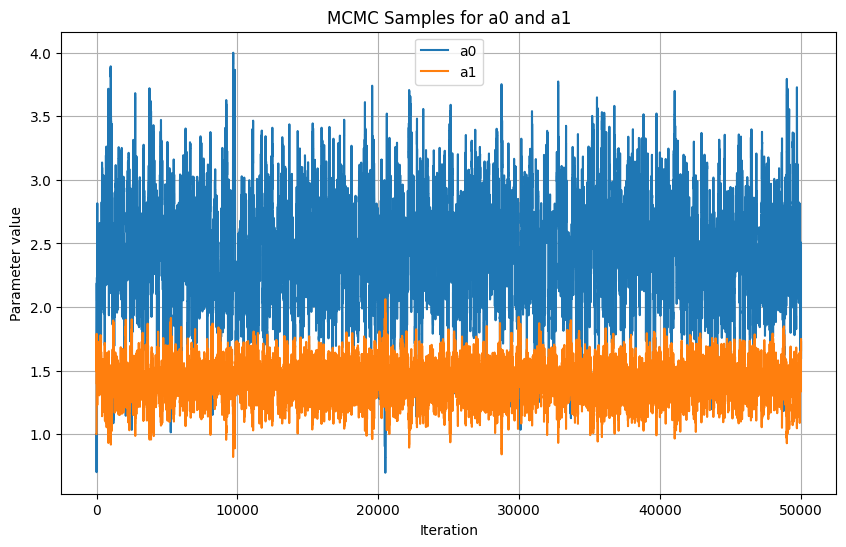

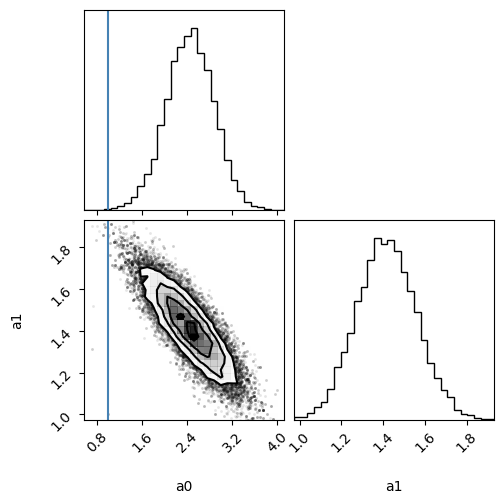

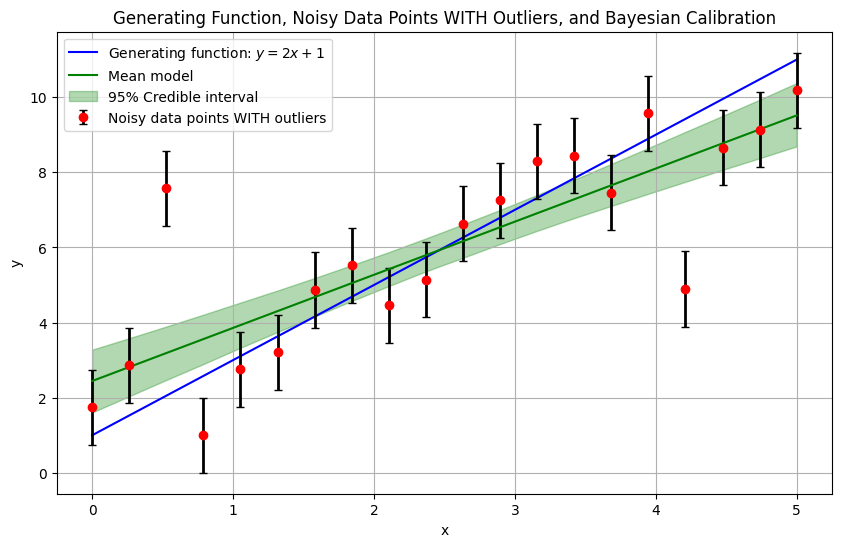

In [39]:
# Bayesian calibration using MCMC with Metropolis-Hastings algorithm
def log_likelihood(a0, a1, x, y, sigma=1):
    y_model = a0 + a1 * x
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2)

def log_prior(a0, a1):
    return 0  # Assuming flat priors

def log_posterior(a0, a1, x, y, sigma=1):
    return log_prior(a0, a1) + log_likelihood(a0, a1, x, y, sigma)

# Initial guess
a0, a1 = 1, 1
n_iterations = 50000
sigma_proposal = 0.2

# Storage for samples
samples = np.zeros((n_iterations, 2))
samples[0, :] = [a0, a1]

# Count the number of acceptances
n_acceptances = 0

for i in range(1, n_iterations):
    a0_proposal = a0 + np.random.normal(0, sigma_proposal)
    a1_proposal = a1 + np.random.normal(0, sigma_proposal)
    
    log_posterior_current = log_posterior(a0, a1, x, y, sigma=1)
    log_posterior_proposal = log_posterior(a0_proposal, a1_proposal, x, y, sigma=1)
    
    acceptance_prob = np.exp(log_posterior_proposal - log_posterior_current)
    
    if np.random.rand() < acceptance_prob:
        a0, a1 = a0_proposal, a1_proposal
        n_acceptances += 1
    
    samples[i, :] = [a0, a1]

# Calculate and print the acceptance ratio
acceptance_ratio = n_acceptances / n_iterations
print(f'Acceptance ratio: {acceptance_ratio:.2f}')

# Plotting the samples
plt.figure(figsize=(10, 6))
plt.plot(samples[:, 0], label='a0')
plt.plot(samples[:, 1], label='a1')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()
plt.title('MCMC Samples for a0 and a1')
plt.grid(True)
plt.show()

# Corner plot with better limits
import corner

# Determine the limits for the corner plot
a0_min, a0_max = np.percentile(samples[:, 0], [1, 99])*(0.4,1.2)
a1_min, a1_max = np.percentile(samples[:, 1], [1, 99])*(0.9,1.1)

corner.corner(samples, labels=["a0", "a1"], truths=[1, 2], range=[(a0_min, a0_max), (a1_min, a1_max)], bins=30)
plt.show()

# Sampling 10,000 curves from the visited samples
n_samples = 10000
indices = np.random.choice(range(n_iterations), n_samples, replace=True)
sampled_a0 = samples[indices, 0]
sampled_a1 = samples[indices, 1]

# Generate y values for each sampled parameter set
y_samples = np.array([a0 + a1 * x for a0, a1 in zip(sampled_a0, sampled_a1)])

# Calculate mean and credible intervals for each x
y_mean = np.mean(y_samples, axis=0)
y_lower = np.percentile(y_samples, 2.5, axis=0)
y_upper = np.percentile(y_samples, 97.5, axis=0)

# Plotting the estimated mean model and credible intervals
plt.figure(figsize=(10, 6))
plt.plot(x, y_true, label='Generating function: $y = 2x + 1$', color='blue')
plt.errorbar(x, y, yerr=noise_size, fmt='o', color='red', label='Noisy data points WITH outliers', ecolor='black', elinewidth=2, capsize=3)
plt.plot(x, y_mean, label='Mean model', color='green')
plt.fill_between(x, y_lower, y_upper, color='green', alpha=0.3, label='95% Credible interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Generating Function, Noisy Data Points WITH Outliers, and Bayesian Calibration')
plt.grid(True)
plt.show()


Indeed, now our confidence interval does not encompass the true generating function. Lets find a workaround this!

## Using a heavy tail distribution 

Acceptance ratio: 0.43


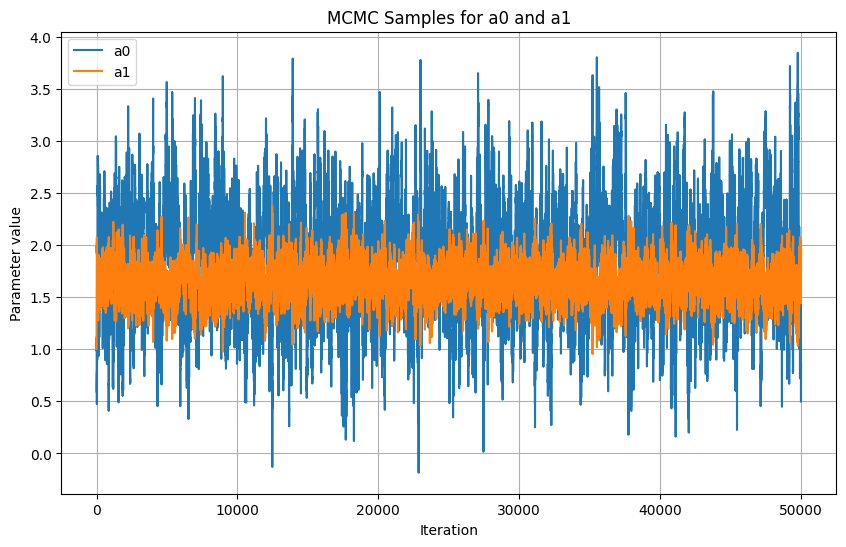

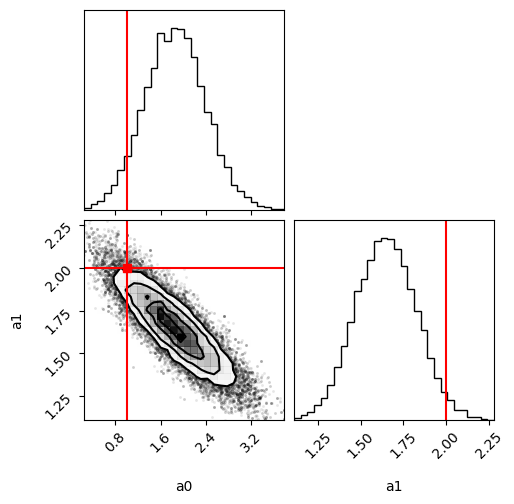

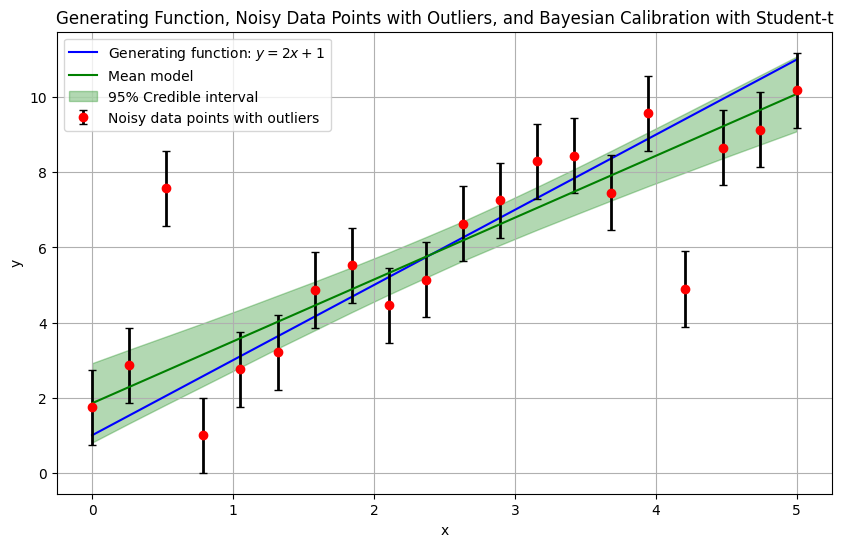

In [41]:
import scipy.stats as stats

# Degrees of freedom for the Student's t-distribution
nu = 3

# Bayesian calibration using MCMC with Metropolis-Hastings algorithm
def log_likelihood(a0, a1, x, y, sigma=1, nu=3):
    y_model = a0 + a1 * x
    # Student's t-distribution log-likelihood
    return np.sum(stats.t.logpdf(y - y_model, df=nu, scale=sigma))

def log_prior(a0, a1):
    return 0  # Assuming flat priors

def log_posterior(a0, a1, x, y, sigma=1, nu=3):
    return log_prior(a0, a1) + log_likelihood(a0, a1, x, y, sigma, nu)

# Initial guess
a0, a1 = 1, 1
n_iterations = 50000
sigma_proposal = 0.2

# Storage for samples
samples = np.zeros((n_iterations, 2))
samples[0, :] = [a0, a1]

# Count the number of acceptances
n_acceptances = 0

for i in range(1, n_iterations):
    a0_proposal = a0 + np.random.normal(0, sigma_proposal)
    a1_proposal = a1 + np.random.normal(0, sigma_proposal)
    
    log_posterior_current = log_posterior(a0, a1, x, y, sigma=1, nu=nu)
    log_posterior_proposal = log_posterior(a0_proposal, a1_proposal, x, y, sigma=1, nu=nu)
    
    acceptance_prob = np.exp(log_posterior_proposal - log_posterior_current)
    
    if np.random.rand() < acceptance_prob:
        a0, a1 = a0_proposal, a1_proposal
        n_acceptances += 1
    
    samples[i, :] = [a0, a1]

# Calculate and print the acceptance ratio
acceptance_ratio = n_acceptances / n_iterations
print(f'Acceptance ratio: {acceptance_ratio:.2f}')

# Plotting the samples
plt.figure(figsize=(10, 6))
plt.plot(samples[:, 0], label='a0')
plt.plot(samples[:, 1], label='a1')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()
plt.title('MCMC Samples for a0 and a1')
plt.grid(True)
plt.show()


# Determine the limits for the corner plot
a0_min, a0_max = np.percentile(samples[:, 0], [1, 99])*(0.4,1.2)
a1_min, a1_max = np.percentile(samples[:, 1], [1, 99])*(0.9,1.1)

corner.corner(samples, labels=["a0", "a1"], truths=[1, 2],truth_color='r', range=[(a0_min, a0_max), (a1_min, a1_max)], bins=30)
plt.show()

# Sampling 10,000 curves from the visited samples
n_samples = 10000
indices = np.random.choice(range(n_iterations), n_samples, replace=True)
sampled_a0 = samples[indices, 0]
sampled_a1 = samples[indices, 1]

# Generate y values for each sampled parameter set
y_samples = np.array([a0 + a1 * x for a0, a1 in zip(sampled_a0, sampled_a1)])

# Calculate mean and credible intervals for each x
y_mean = np.mean(y_samples, axis=0)
y_lower = np.percentile(y_samples, 2.5, axis=0)
y_upper = np.percentile(y_samples, 97.5, axis=0)

# Plotting the estimated mean model and credible intervals
plt.figure(figsize=(10, 6))
plt.plot(x, y_true, label='Generating function: $y = 2x + 1$', color='blue')
plt.errorbar(x, y, yerr=noise_size, fmt='o', color='red', label='Noisy data points with outliers', ecolor='black', elinewidth=2, capsize=3)
plt.plot(x, y_mean, label='Mean model', color='green')
plt.fill_between(x, y_lower, y_upper, color='green', alpha=0.3, label='95% Credible interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Generating Function, Noisy Data Points with Outliers, and Bayesian Calibration with Student-t')
plt.grid(True)
plt.show()


Now that we have used a more heavy tail distribution our estimation with the true function is much better! Hurray for us for understanding that the choice of likelihood matters a lot!